In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.2  Device :  cuda


오디오들이 
1초, 2초, 3초 각각 다르다.

음성이 뭉개진 데이터도 있다.

In [2]:
import numpy as np
np.__version__

'1.21.5'

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)
sr=50000

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = '../voice_data/fusion/pathology/phrase/105-phrase.wav'
sig, sr = librosa.load(audio_path, sr=sr)# 논문에서 f_s = 50 000HZ
length=318596
pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
#sig = pad1d(sig,length)  

#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time=sig.shape[0]/sr
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

(174653,) 50000
3.49306


In [4]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

#audio_path = './voice_data/disorder/export/blues.00000.wav'
#audio_path = './voice_data/disorder/export/105-phrase.wav'
audio_path = '../voice_data/fusion/pathology/a/107-a_n.wav'
sig_healthy, sr_sig_healthy = librosa.load(audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
#length=318596
#sig = pad1d(sig_healthy,length)  


#모음데이터는 1초에서 3초로 sampling 했다고 한다. (2초)

print(sig.shape,sr)
print(sig.shape[0]/sr)
sr_time_sig_healthy=sig.shape[0]/sr
print(sr_time_sig_healthy)
#155269 sample임을 알 수 있고
#sampling frame이 50000이다.
#시간 : 155269/50000

#음성 파일마다 sample수가 달라서, cnn은 통일해야한다.
#통일안하면, mfcc frame수도 달라진다.

(174653,) 50000
3.49306
3.49306


In [5]:
healthy_audios = []
disorder_audios = []

healthy_audios.append('../voice_data/fusion/healthy/phrase/1-phrase.wav')
healthy_audios.append('../voice_data/fusion/healthy/phrase/2-phrase.wav')
healthy_audios.append('../voice_data/fusion/healthy/phrase/3-phrase.wav')

disorder_audios.append('../voice_data/fusion/pathology/phrase/108-phrase.wav')
disorder_audios.append('../voice_data/fusion/pathology/phrase/109-phrase.wav')
disorder_audios.append('../voice_data/fusion/pathology/phrase/110-phrase.wav')


healthy_audios =[ librosa.load(aud, sr=50000)[0] for aud in healthy_audios ]
disorder_audios =[ librosa.load(aud, sr=50000)[0] for aud in disorder_audios ]



Text(0.5, 1.0, 'Waveform')

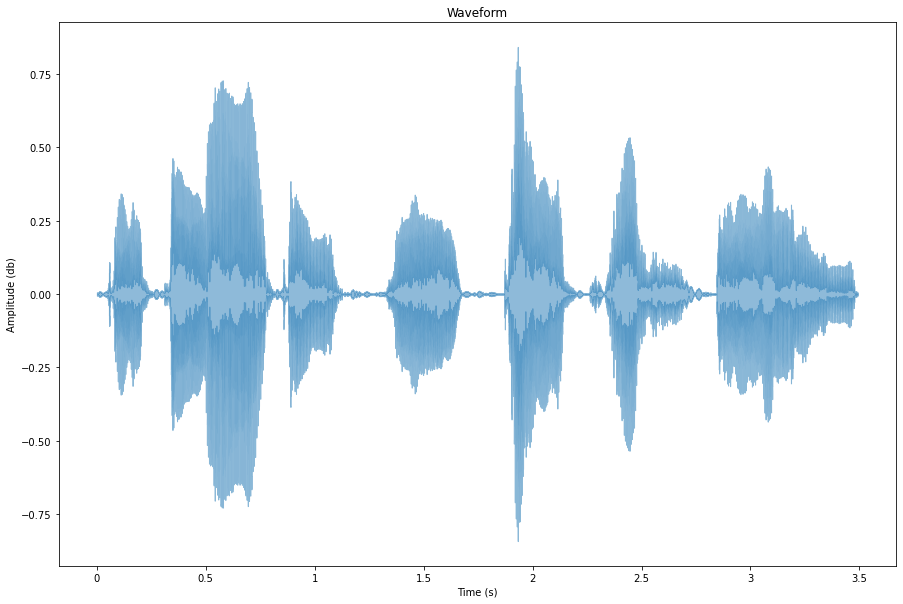

In [6]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(sig, sr=sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (db)")
plt.title("Waveform")

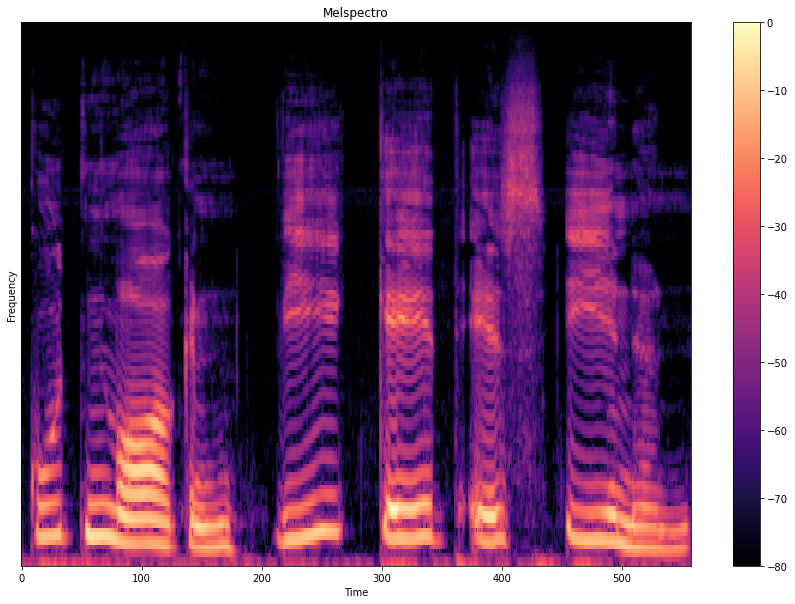

(128, 558)


In [7]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.

win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다. (stride)
#hop: 윈도우가 겹치는 사이즈

#hop_length가 mfcc의 frame수를 결정한다.


mel = librosa.feature.melspectrogram(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("Frequency")
plt.colorbar()
plt.title("Melspectro")

# show plots
plt.show()
print(mel.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

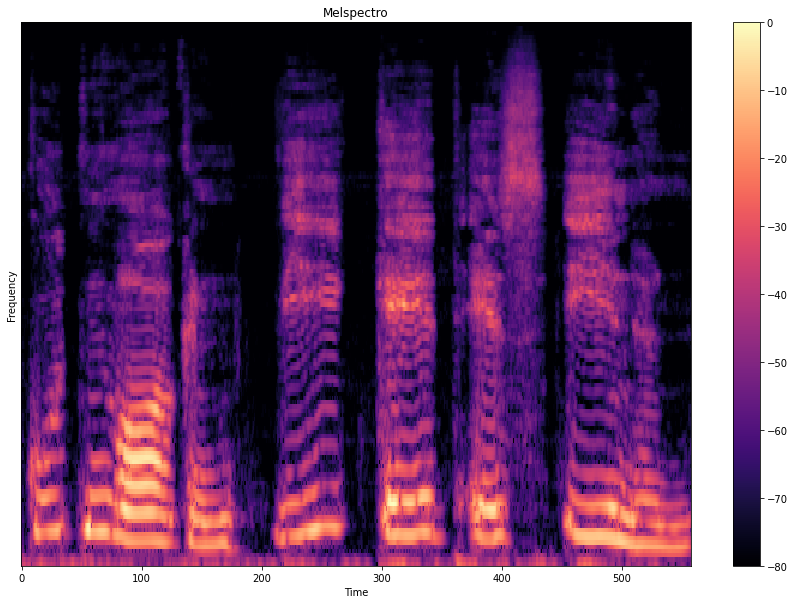

(128, 558)


In [23]:
sig_change = librosa.effects.pitch_shift(sig,sr=sr,n_steps=2)


mel = librosa.feature.melspectrogram(y=sig_change, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("Frequency")
plt.colorbar()
plt.title("Melspectro")

# show plots
plt.show()
print(mel.shape)

In [25]:
import torchaudio
import torchaudio.transforms as T

In [10]:
import IPython

In [32]:
sig

array([0.00521851, 0.00506592, 0.00500488, ..., 0.0017395 , 0.0020752 ,
       0.0022583 ], dtype=float32)

tensor([0.0052, 0.0051, 0.0050,  ..., 0.0017, 0.0021, 0.0023],
       dtype=torch.float64)

In [43]:
pts=T.PitchShift(n_steps=2,sample_rate=16000)
pts(torch.from_numpy(sig).type(torch.float64))

tensor([ 0.0049,  0.0052,  0.0050,  ..., -0.0011, -0.0012, -0.0011],
       dtype=torch.float64)

In [15]:
IPython.display.Audio(data=sig, rate=sr)

In [24]:
IPython.display.Audio(data=sig_change, rate=sr)